In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [9]:
stock_symbol = 'TSLA'
df = yf.download(stock_symbol, start='2015-01-01', end='2023-01-01')
df.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


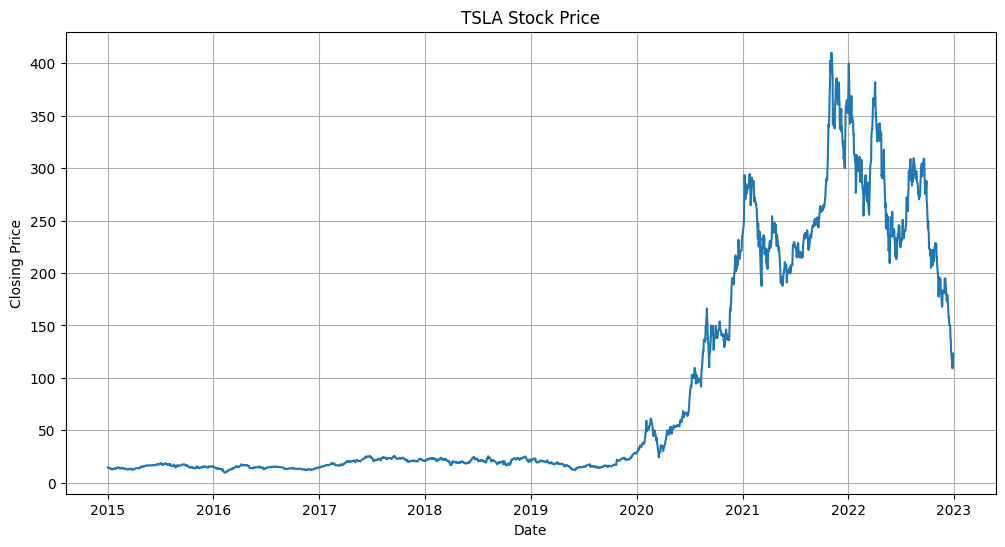

In [10]:

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title(f'{stock_symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


In [13]:
from sklearn.preprocessing import MinMaxScaler
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [14]:

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)


In [15]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)


In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=32)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0095
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 5.4827e-04
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 2.8607e-04
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 2.9301e-04
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 3.7338e-04
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 2.5490e-04
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 2.3353e-04
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 2.9284e-04
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 2.1327e-04
Epoch 10/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 2.7647e-04
Epoch 11/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 2.0946e-04
Epoch 12/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.0661e-04
Epoch 13/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.8023e-04
Epoch 14/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.9680e-04
Epoch

In [17]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_scaled = y_test.reshape(-1, 1)
y_test_original = scaler.inverse_transform(y_test_scaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [18]:

last_60_days = scaled_data[-60:]
X_input = np.reshape(last_60_days, (1, 60, 1))
prediction = model.predict(X_input)
prediction = scaler.inverse_transform(prediction)
print(f'The predicted stock price for tomorrow is: {prediction[0][0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The predicted stock price for tomorrow is: 124.85425567626953


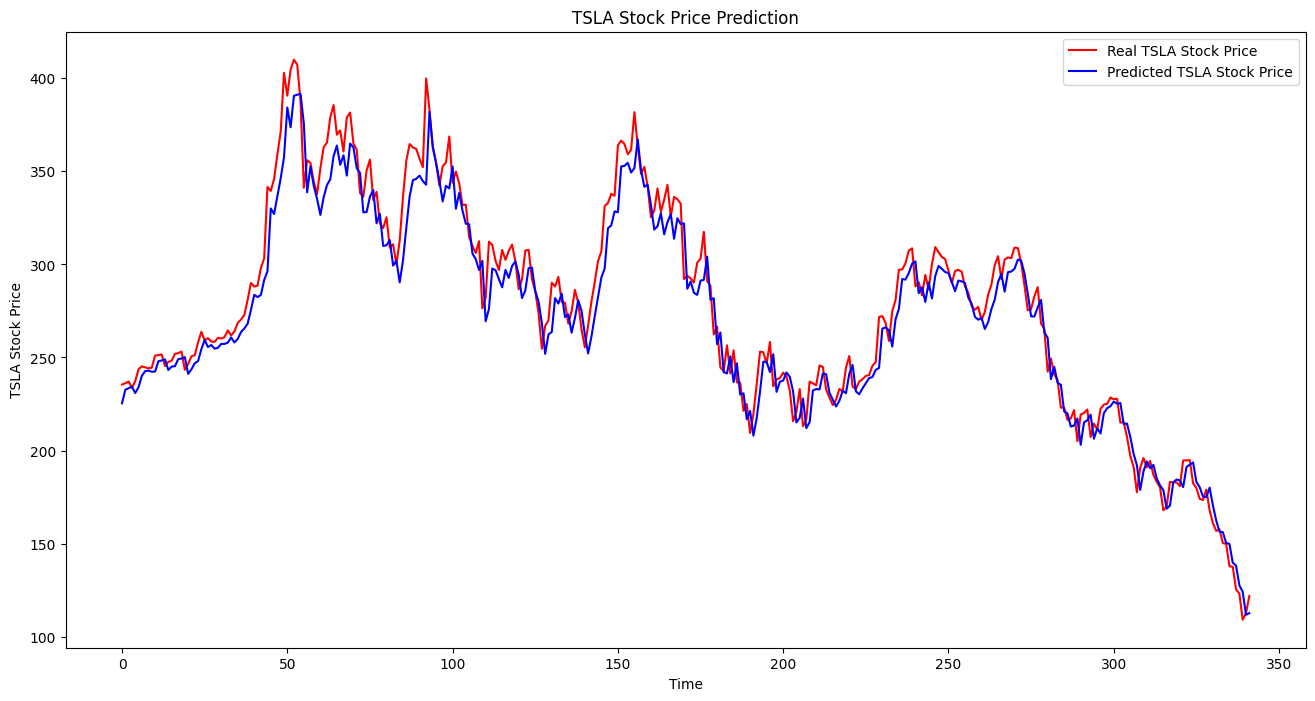

In [19]:
import matplotlib.pyplot as plt
def plot_predictions(test_set, predicted_stock_price):
  """
  Plots the actual stock prices against the predicted stock prices.

  Args:
      test_set: The actual stock prices from the test set.
      predicted_stock_price: The predicted stock prices.
  """

  plt.figure(figsize=(16, 8))
  plt.plot(test_set, color='red', label='Real TSLA Stock Price')
  plt.plot(predicted_stock_price, color='blue', label='Predicted TSLA Stock Price')
  plt.title('TSLA Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('TSLA Stock Price')
  plt.legend()
  plt.show()


# Assuming you have your test_set and predicted_stock_price variables defined
plot_predictions(y_test[0], predictions)
